## 1. Business Understanding
Proyek ini bertujuan untuk membangun model transfer learning yang dapat mengklasifikasikan 5 jenis penyakit kulit. Teknik yang digunakan adalah Transfer Learning, dengan menggunakan model pre-trained Xception. Model ini akan membantu dalam deteksi penyakit kulit dengan lebih akurat dan lebih cepat, sehingga dapat mendukung diagnosis medis. Metode yang digunakan pada proyek ini adalah Cross-Industry Standard Process for Data Mining (CRISP-DM).

## 2. Data Understanding
Tahap ini berfokus pada persiapan dan pemahaman data yang digunakan dalam model, serta proses eksplorasi dan visualisasi data untuk memahami distribusi gambar penyakit kulit.

### 2.1 Data Preparation
Di sini, kita mengimpor berbagai pustaka yang diperlukan, seperti os, shutil, numpy, pandas, matplotlib, dan lain-lain. Semua pustaka ini membantu dalam manajemen file, pemrosesan gambar, dan visualisasi data.

In [1]:
# Import Libraries yang diperlukan
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage import io, img_as_ubyte
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm as tq
import cv2

2025-05-31 14:02:11.241642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748700131.467093      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748700131.531812      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2.2 Data Loading
Data gambar dibaca dari folder dataset yang berisi gambar-gambar yang telah dikategorikan berdasarkan jenis penyakit kulit (seperti acne, Vitiligo, dll.).

In [2]:
combined_dir = "/kaggle/input/dataset/skinDisease"
categories = ['acne', 'hyperpigmentation', 'Nail_psoriasis', 'SJS-TEN', 'Vitiligo']

In [3]:
# Mengecek jumlah gambar di tiap folder kategori
for category in categories:
    category_dir = os.path.join(combined_dir, category)
    image_files = os.listdir(category_dir)
    print(f"Found {len(image_files)} images in {category} folder.")

Found 1043 images in acne folder.
Found 1028 images in hyperpigmentation folder.
Found 1100 images in Nail_psoriasis folder.
Found 1154 images in SJS-TEN folder.
Found 1100 images in Vitiligo folder.


### 2.3 Data Visualization
Menampilkan sampel gambar dari masing-masing kategori penyakit kulit dan visualisasi distribusi gambar per kategori.

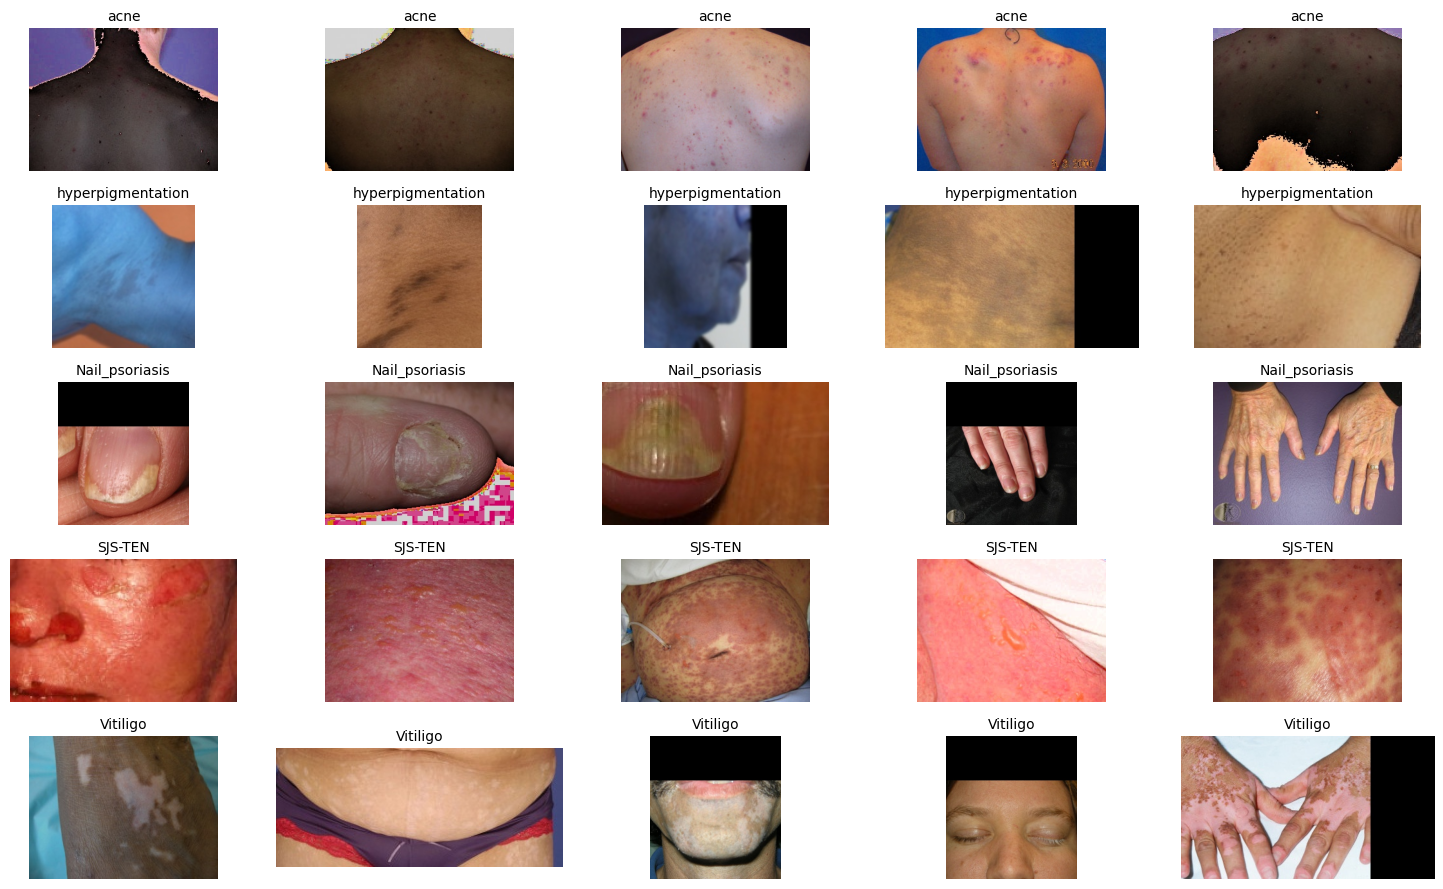

In [4]:
# Menampilkan beberapa sampel gambar dari setiap kategori
fig, axes = plt.subplots(len(categories), 5, figsize=(15, 9))
for i, category in enumerate(categories):
    category_dir = os.path.join(combined_dir, category)
    sample_images = random.sample(os.listdir(category_dir), 5)
    for j in range(5):
        image_path = os.path.join(category_dir, sample_images[j])
        img = Image.open(image_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{category}", fontsize=10)
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Plotting distribusi gambar per kelas
image_counts = []
for category in categories:
    category_dir = os.path.join(combined_dir, category)
    image_files = os.listdir(category_dir)
    image_counts.append(len(image_files))

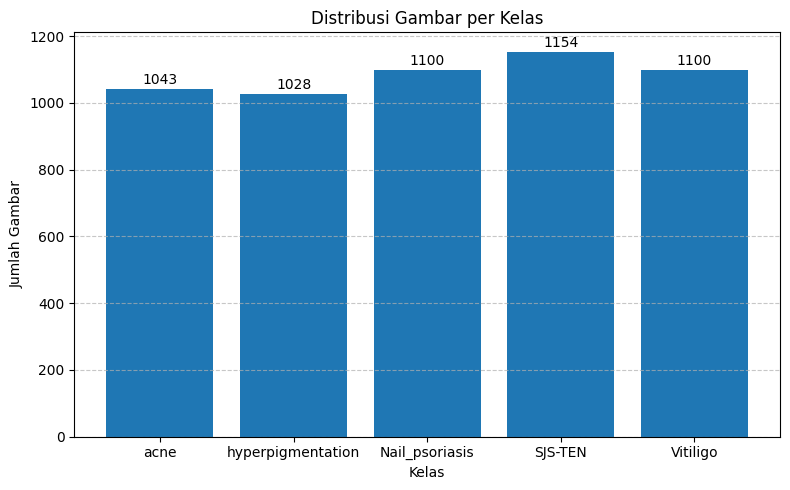

In [6]:
plt.figure(figsize=(8, 5))
bars = plt.bar(categories, image_counts)
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, str(yval), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

## 3. Data Preparation
Persiapan data dilakukan dengan membuat DataFrame yang berisi path gambar dan label, kemudian membagi data menjadi data latih dan data uji.

In [7]:
# Menyusun DataFrame yang berisi path dan label
mypath = '/kaggle/input/dataset/skinDisease'
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

In [8]:
# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path": full_path, 'file_name': file_name, 'labels': labels})

In [9]:
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
Nail_psoriasis       1100
SJS-TEN              1154
Vitiligo             1100
acne                 1043
hyperpigmentation    1028
dtype: int64

In [10]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

In [11]:
# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

Data dibagi menjadi dua bagian: data latih (80%) dan data uji (20%) menggunakan train_test_split() dari sklearn.

In [12]:
# Menyatukan kedalam masing-masing dataframe
df_all = pd.concat([df_tr, df_te], ignore_index=True)

In [13]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 4340
test size 1085


In [14]:
# Menggabungkan DataFrame df_tr dan df_te
dataset_path = "/kaggle/working/finalDataset/"

In [15]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if not os.path.exists(file_path):
        file_path = os.path.join(mypath, row['labels'], row['file_name'])

    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(dest_dir, exist_ok=True)

    destination_file_name = os.path.basename(file_path)  
    file_dest = os.path.join(dest_dir, destination_file_name)

    if not os.path.exists(file_dest):
        try:
            shutil.copy2(file_path, file_dest)
        except FileNotFoundError:
            print(f"[File tidak ditemukan] → {file_path}")

0it [00:00, ?it/s]

In [16]:
TRAIN_DIR = "/kaggle/working/finalDataset/train"
TEST_DIR = "/kaggle/working/finalDataset/test"

In [17]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = datagen.flow_from_directory(
    TRAIN_DIR, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 3474 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 1085 images belonging to 5 classes.


In [19]:
print(train_generator.class_indices)

{'Nail_psoriasis': 0, 'SJS-TEN': 1, 'Vitiligo': 2, 'acne': 3, 'hyperpigmentation': 4}


## 4. Modelling
Pada tahap ini, kita memuat model Xception yang sudah dilatih sebelumnya (pre-trained) dan menambahkan lapisan-lapisan tambahan untuk menyesuaikan model dengan tugas klasifikasi penyakit kulit.

In [20]:
# Memuat base model Xception
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

I0000 00:00:1748700189.215260      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748700189.215997      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model Xception yang sudah dilatih pada dataset ImageNet digunakan sebagai base model dan kita membekukan bobot-bobotnya untuk hanya melatih lapisan tambahan.

In [21]:
model = Sequential([
    base_model,
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # Keluaran 5 kelas
])

Menambahkan lapisan-lapisan seperti Conv2D, MaxPooling2D, Flatten, Dense, dan Dropout untuk model akhir.

In [22]:
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Early stopping custom callback
class EarlyStoppingCustomBothAcc(Callback):
    def __init__(self, target_accuracy=0.98):
        super().__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc is not None and val_acc is not None:
            if train_acc >= self.target_accuracy and val_acc >= self.target_accuracy:
                print(f"\nEpoch {epoch+1}: Training & Validation Accuracy mencapai target {self.target_accuracy*100:.2f}%. Training model diberhentikan.")
                self.model.stop_training = True

In [24]:
earlystop_keras = EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

In [25]:
reduce_learningRate = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [26]:
callbacks = [EarlyStoppingCustomBothAcc(target_accuracy=0.98), earlystop_keras, reduce_learningRate]

In [27]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1748700199.303871     120 service.cc:148] XLA service 0x7ecad8002160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748700199.304698     120 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748700199.304716     120 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748700200.292207     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/109 ━━━━━━━━━━━━━━━━━━━━ 30:07 17s/step - accuracy: 0.1250 - loss: 2.0085

I0000 00:00:1748700208.957388     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


109/109 ━━━━━━━━━━━━━━━━━━━━ 44s 257ms/step - accuracy: 0.4372 - loss: 1.3551 - val_accuracy: 0.8533 - val_loss: 0.5009 - learning_rate: 1.0000e-04
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 0.8071 - loss: 0.5472 - val_accuracy: 0.8995 - val_loss: 0.2967 - learning_rate: 1.0000e-04
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 0.8904 - loss: 0.3088 - val_accuracy: 0.9273 - val_loss: 0.2317 - learning_rate: 1.0000e-04
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 0.9384 - loss: 0.2059 - val_accuracy: 0.9330 - val_loss: 0.2055 - learning_rate: 1.0000e-04
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.9503 - loss: 0.1385 - val_accuracy: 0.9446 - val_loss: 0.1989 - learning_rate: 1.0000e-04
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.9685 - loss: 0.0988 - val_accuracy: 0.9480 - val_loss: 0.1648 - learning_rate: 1.0000e-04
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - 

## 5. Evaluation
Setelah melatih model, dilakukan evaluasi untuk mengukur performa model pada data latih, validasi, dan uji.

In [28]:
# Evaluasi pada data training, validasi, dan testing
loss_train, accuracy_train = model.evaluate(train_generator)
loss_val, accuracy_val = model.evaluate(validation_generator)
loss_test, accuracy_test = model.evaluate(test_generator)

109/109 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.9994 - loss: 0.0136
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9510 - loss: 0.1987
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 305ms/step - accuracy: 0.9711 - loss: 0.0851


Evaluasi dilakukan untuk mendapatkan akurasi dan loss dari data latih, validasi, dan uji.

In [29]:
# Hasil evaluasi
print(f"Training Accuracy: {accuracy_train}, Training Loss: {loss_train}")
print(f"Validation Accuracy: {accuracy_val}, Validation Loss: {loss_val}")
print(f"Test Accuracy: {accuracy_test}, Test Loss: {loss_test}")

Training Accuracy: 0.9988486170768738, Training Loss: 0.013494889251887798
Validation Accuracy: 0.957274854183197, Validation Loss: 0.16441942751407623
Test Accuracy: 0.9631336331367493, Test Loss: 0.1136525571346283


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [31]:
plt.figure(figsize=(12, 5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Training vs Validation Accuracy')

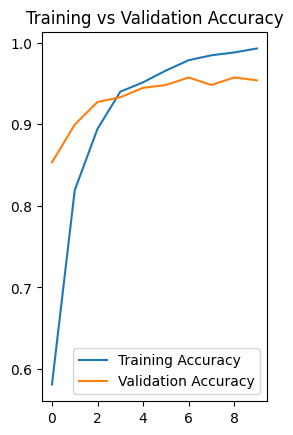

In [32]:
# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

Menampilkan grafik akurasi dan loss selama pelatihan dan validasi.

Text(0.5, 1.0, 'Training vs Validation Loss')

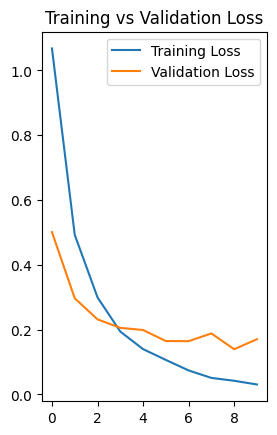

In [33]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training vs Validation Loss')

In [34]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [35]:
# Mendapatkan prediksi
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step


In [36]:
# Mendapatkan label asli
y_true = test_generator.classes

In [37]:
# Nama kelas
class_labels = list(test_generator.class_indices.keys())

In [38]:
# Classification report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_labels))

=== Classification Report ===
                   precision    recall  f1-score   support

   Nail_psoriasis       0.98      0.99      0.99       220
          SJS-TEN       0.95      0.95      0.95       239
         Vitiligo       0.92      0.93      0.93       201
             acne       0.99      0.99      0.99       219
hyperpigmentation       0.97      0.95      0.96       206

         accuracy                           0.96      1085
        macro avg       0.96      0.96      0.96      1085
     weighted avg       0.96      0.96      0.96      1085



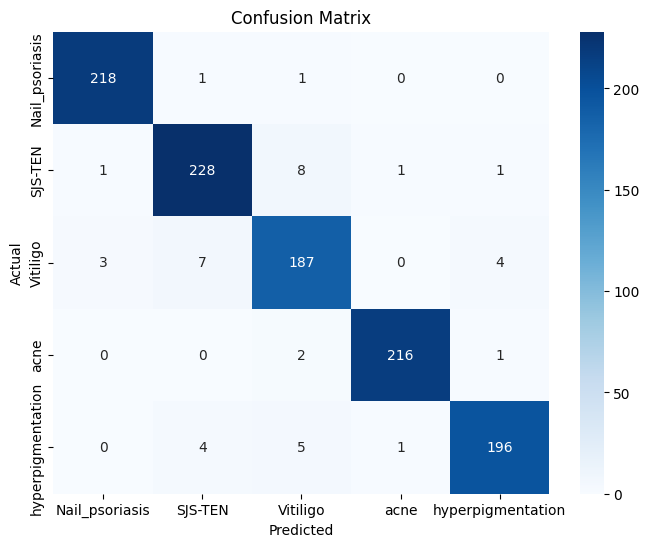

In [39]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 6. Deployment
Setelah model selesai dilatih dan dievaluasi, model disimpan dalam berbagai format untuk di-deploy ke aplikasi lain, seperti TensorFlow Lite untuk penggunaan pada perangkat mobile dan TensorFlow.js untuk penggunaan di web.

In [40]:
model.save('/kaggle/working/finalModel.h5')

In [41]:
# Convert to TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/kaggle/working/finalModel.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpx174rm02'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_132')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139413419245648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413419246032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413419195664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413418601808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413419246608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413418601616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413419195088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413419195856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413419195472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139413419196240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1394134172

W0000 00:00:1748700449.356486      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748700449.356522      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748700449.462155      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


In [42]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [43]:
# Convert to TFJS
!tensorflowjs_converter --input_format=keras /kaggle/working/finalModel.h5 /kaggle/working/finalModel_tfjs

2025-05-31 14:07:39.492610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748700459.514041     496 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748700459.520121     496 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [44]:
# Menyimpan model dalam format .keras
model.save('finalModel.keras')